# FC Classification
1. Prepare Xy
2. fit a simple SVM classifier

In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import skopt
from sklearn.decomposition import PCA, FastICA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import (SelectFromModel, SelectKBest,
                                       VarianceThreshold, f_classif, SelectPercentile,
                                       mutual_info_classif)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
# from umap import UMAP
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, 
                                     ShuffleSplit, StratifiedShuffleSplit, StratifiedGroupKFold,
                                     GroupShuffleSplit, cross_validate, cross_val_score, KFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real
from tqdm import tqdm

# import shap

# # add the hypnotizability data
# hypnotizability = pd.read_excel('data/PLB_HYP_data_MASTER.xlsx', index_col=0)
# hypnotizability = hypnotizability['hypnotizability_total'].iloc[9:59]
# DATA['hypnotizability_total'] = hypnotizability.repeat(4).reset_index(drop=True)
# # drop rows with nan values
# DATA = DATA.dropna(axis=0, how='any').reset_index(drop=True)

# Dataset for the classification
datasets = ['correlation_source', 'correlation_sensor',
            'power_source', 'power_sensor',
            'plv_source']

# set sns style
sns.set_context('talk')
sns.set_style('white')

## Prepare Xy

In [11]:
# read data
DATA = pd.read_csv('data/classification_datasets/power_sensor.csv', index_col=0)

DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('condition.str.contains("experience")')
# DATA = DATA.query('procedure == "confusion" or procedure == "relaxation"')

#Xy
X = DATA.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session', 'condition',
                       'bids_id'])

col_name = [col for col in X.columns if 'gamma' in col]
X = X[col_name]

y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)

In [19]:
DATA = pd.read_csv('data/classification_datasets/power_sensor.csv', index_col=0)
10 ** (DATA.loc[0, 'LF-delta']/10)

5.722458530204265e-13

## Random forest

In [225]:
# svm classifier
NUM_TRIALS = 10
groups = DATA['bids_id']

pipe = Pipeline([
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('reduce', PCA()),
    # ('clf', SVC(kernel="poly", 
    #             # C=12.032891834179356,
    #             # gamma=22.25679198157808,
    #             max_iter=-1,
    #             probability=True,
    #             class_weight='balanced')),
     ('clf', RandomForestClassifier(n_estimators=400)),
])

# stratified split
CV = StratifiedGroupKFold(n_splits=5, shuffle=True)
scores = []
for i in tqdm(range(NUM_TRIALS)):
    score = cross_val_score(pipe, X, y, cv=CV, groups=groups, scoring='accuracy')
    scores.append(score)
np.array(scores).mean()

# shuffled split
# CV =GroupShuffleSplit(n_splits=100, test_size=0.2)
# score = cross_val_score(pipe, X, y, cv=CV, groups=groups, scoring='accuracy')
# score.mean()

100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


0.6082339940760992

In [223]:
params = {
    'reduce__n_components': [None, 2, 5, 10, 0.95, 0.99, 0.8],
    'clf__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
}

clf = GridSearchCV(pipe, params, cv=CV, n_jobs=-1, scoring='balanced_accuracy', error_score=0)
clf.fit(X, y, groups=groups)
clf.best_params_, clf.best_score_
# y_pred = clf.predict(X.iloc[test])
# test_accuraies.append((y.iloc[test] == y_pred).mean())

({'clf__n_estimators': 400, 'reduce__n_components': 0.99}, 0.6571694971694972)

## Examine the relation between features and target
1. Using, correlation
2. Pairplots

In [ ]:
# find top correlations in each dataset
freqs = ['delta', 'theta', 'alpha', 'beta', 'gamma']
top = 3 # number of top correlations to keep

# initialize a dataframe container 
correlations = pd.DataFrame()
top_features_df = pd.DataFrame()

for df in datasets:
    for freq in freqs:
        data = pd.read_csv(f'data/classification_datasets/{df}.csv', index_col=0)
        data = data.query('condition.str.contains("experience")')
        data.sort_values('condition', inplace=True)
        data.reset_index(drop=True, inplace=True)
        
        y = data['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)
    
        data.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session', 'condition', 'bids_id'], inplace=True)
        
        # get the column names for the frequency
        col_name = [col for col in data.columns if freq in col]
        data = data[col_name]
        
        # change the columns name for plv dataset (because its identical to the correlation_source)
        if df == 'plv_source':
            data.columns = ['plv-' + col for col in data.columns]
    
        # Correlation
        corr = data.corrwith(y).sort_values(ascending=False)
        
        # top and bottom three correlations
        corr_tops = pd.concat([corr.nlargest(top),
                               corr.nsmallest(top)], axis=0)
        
        # Concatenate correlations and dataframes
        correlations = pd.concat([correlations,
                                  corr_tops], axis=0)
        
        top_features_df = pd.concat([top_features_df,
                                     data[corr_tops.index]], axis=1)

correlations.rename(columns={0: 'hypnosis_depth_correlation'}, inplace=True)
# correlations.sort_values(by='hypnosis_depth_correlation', ascending=False, inplace=True)

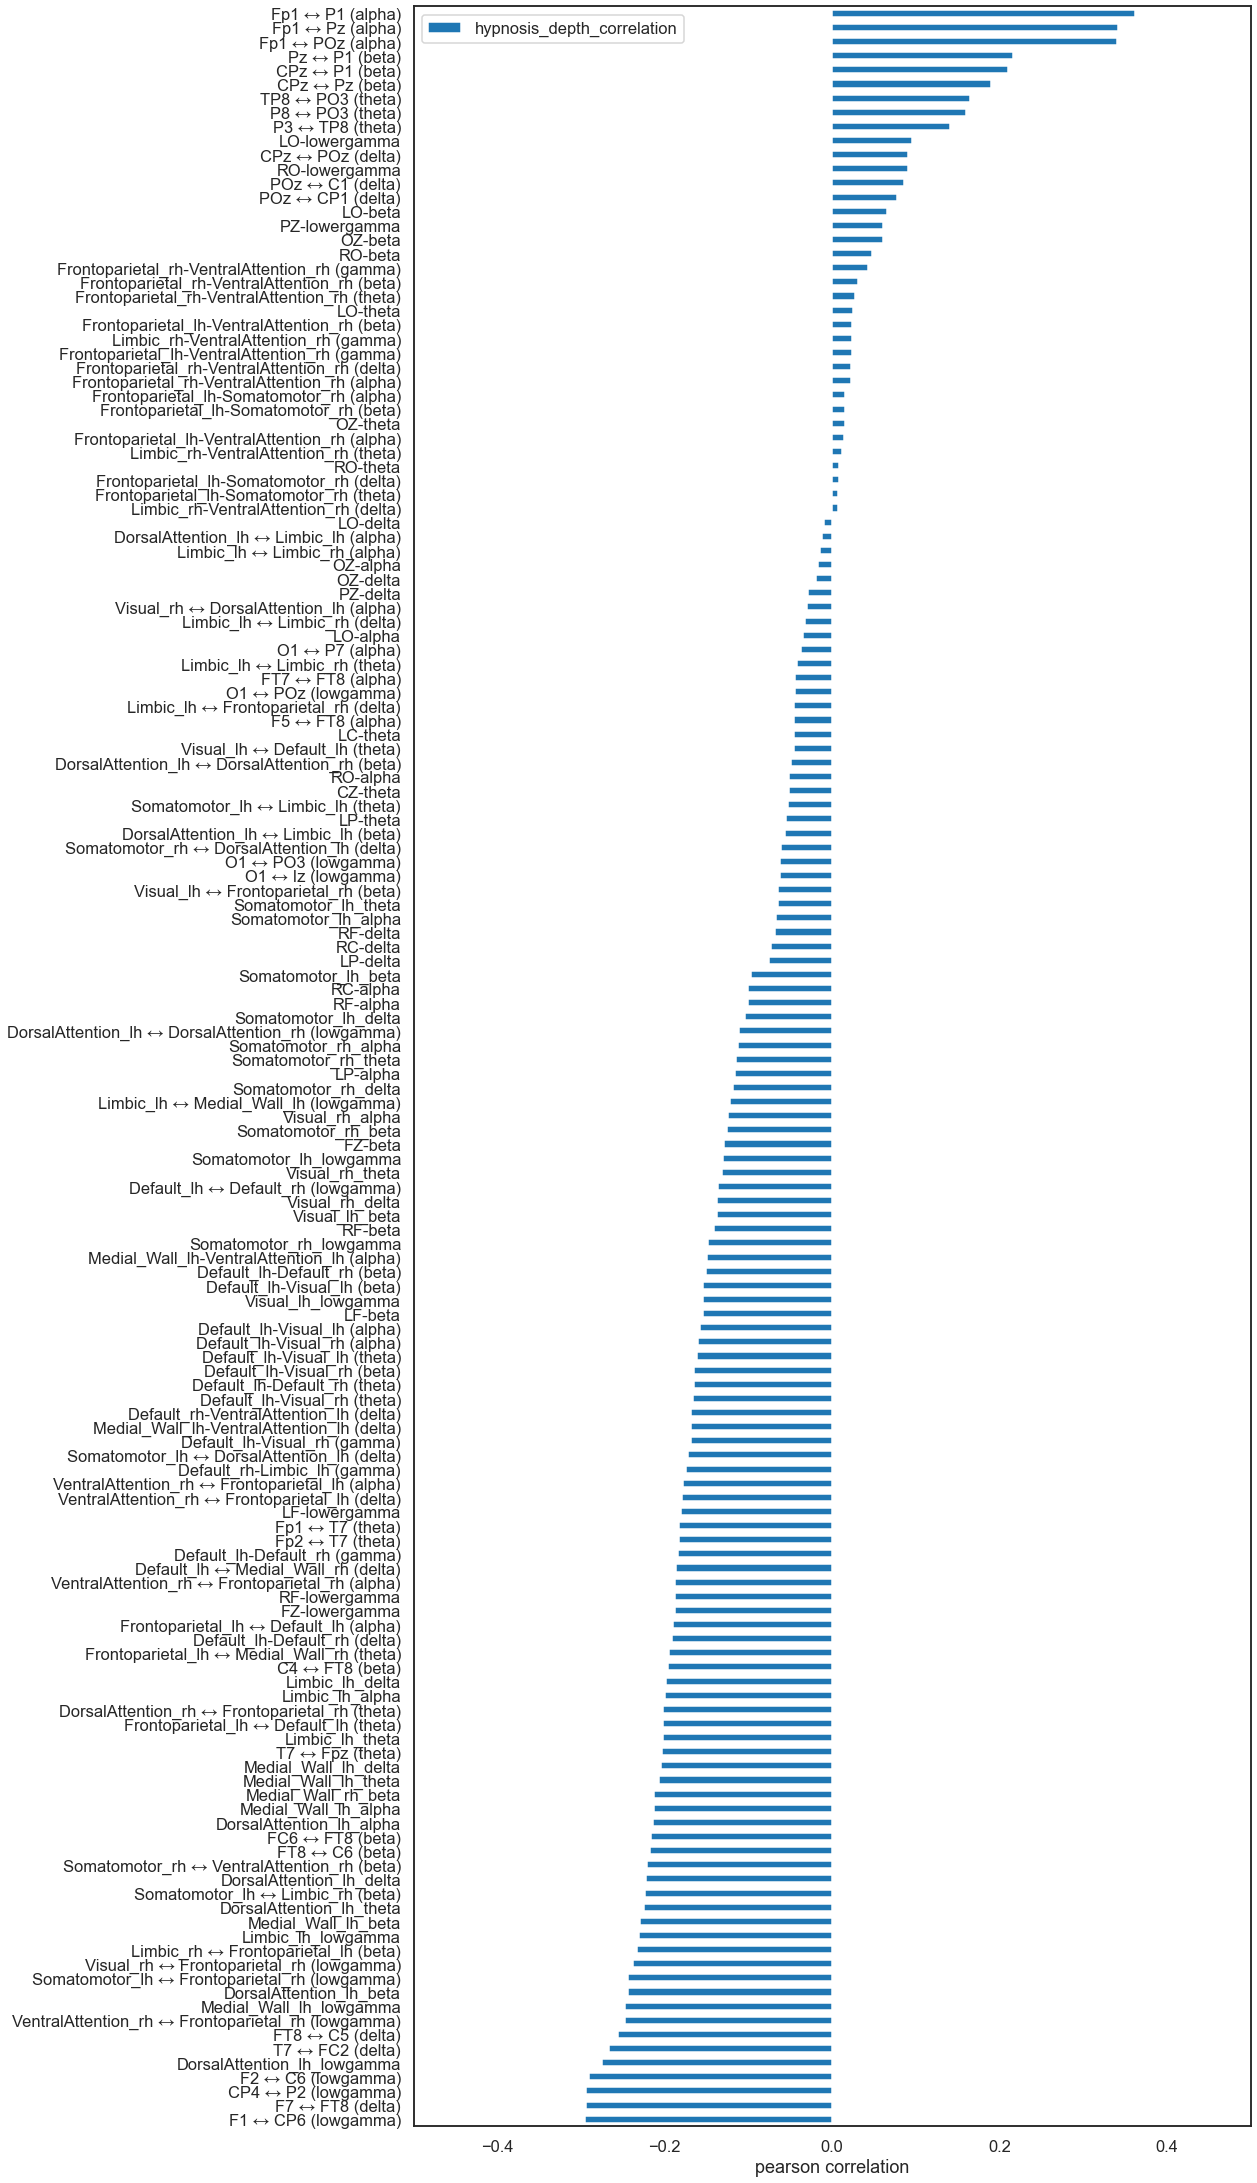

In [82]:
# plot correlation
fig, ax = plt.subplots(figsize=(15, 39))
correlations.sort_values('hypnosis_depth_correlation').plot(kind='barh', ax=ax)
ax.set(xlim=[-0.5, 0.5], xlabel='pearson correlation');

/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_48842/4153689694.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'hypnosis_depth'] = y
/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_48842/4153689694.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['y'] = y


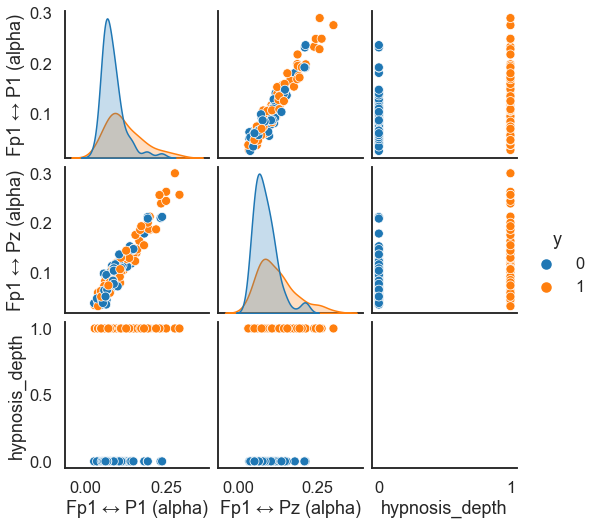

In [134]:
# plot pairplot for the top correlations
idx = correlations.nlargest(2, columns='hypnosis_depth_correlation').index
X = top_features_df[idx]
X.loc[:, 'hypnosis_depth'] = y
X['y'] = y
sns.pairplot(X, hue='y')

In [145]:
from sklearn.preprocessing import MinMaxScaler
pipe = Pipeline([
        ('zerovar', VarianceThreshold(threshold=0.0)),
        ('scale', StandardScaler()),
        # ('select', SelectFromModel(SVC(kernel='linear', probability=True), max_features=13)),
        # ('reduce', PCA(n_components=0.8)),
        ('clf', SVC(kernel="linear",
                    C=0.1,
                    gamma='auto',
                    max_iter=-1,
                    probability=True
                    )),
    ])

## SVM Classifier
We want to compare the accuracy of the models trained on the entire data with a relatively low regularization parameter (C=0.1).

In [157]:
# Cv strategy
CV = StratifiedGroupKFold(n_splits=100, shuffle=True)

freqs = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'all']

scores = {}

for df in datasets:
    for freq in freqs:
        # read data
        DATA = pd.read_csv(f'data/classification_datasets/{df}.csv', index_col=0)

        DATA = DATA.query('description == "hypnosis"')
        DATA = DATA.query('condition.str.contains("experience")')
        # DATA = DATA.query('procedure == "confusion" or procedure == "relaxation"')
        groups = DATA['bids_id']
        
        if df == 'power_source':
            DATA.fillna(0, inplace=True)

        #Xy
        X = DATA.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session', 'condition',
                               'bids_id'])
        
        if freq != 'all':
            col_name = [col for col in X.columns if freq in col]
            X = X[col_name]

        y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)


        # pipeline
        pipe = Pipeline([
            ('zerovar', VarianceThreshold(threshold=0.0)),
            ('scale', StandardScaler()),
            ('select', SelectFromModel(SVC(kernel='linear', probability=True), max_features=13)),
            # ('reduce', PCA(n_components=0.8)),
            ('clf', SVC(kernel="linear",
                        C=0.1,
                        gamma='auto',
                        max_iter=-1,
                        probability=True
                        )),
        ])

        pipe.fit(X, y)
        scores[df+'-'+freq] = pipe.score(X, y)


<AxesSubplot:xlabel='frequencies', ylabel='None-index'>

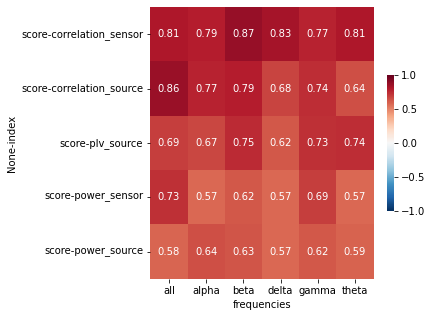

In [39]:
score_df = pd.DataFrame(scores, index=['score']).T.reset_index()
score_df['frequencies'] = score_df['index'].apply(lambda x: x.split('-')[-1])
score_df['index'] = score_df['index'].apply(lambda x: x.split('-')[0])
score_df = score_df.pivot('frequencies', 'index').T
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(score_df, ax=ax, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, cbar_kws={"shrink": 0.5})

In [ ]:
from sklearn.metrics import plot_confusion_matrix
train, test = next(CV.split(X, y, groups=groups))
# pipe.fit(X.iloc[train], y.iloc[train])
# plot_confusion_matrix(pipe, X.iloc[test], y.iloc[test], values_format='d')

pipe.fit(X, y)
plot_confusion_matrix(pipe, X, y, values_format='d')

In [13]:
params = [{
    'clf__C': scipy.stats.expon(scale=100),
    'clf__degree': scipy.stats.randint(1, 5),
    'clf__coef0': scipy.stats.uniform(0, 1),
}]

grid = RandomizedSearchCV(pipe,
                          param_distributions=params,
                          n_iter=100,
                          cv=CV,
                          n_jobs=-1,
                          scoring='accuracy',
                          error_score=0)

grid.fit(X, y, groups=groups)

RandomizedSearchCV(cv=GroupShuffleSplit(n_splits=100, random_state=None, test_size=0.2,
         train_size=None),
                   error_score=0,
                   estimator=Pipeline(steps=[('zerovar', VarianceThreshold()),
                                             ('scale', StandardScaler()),
                                             ('select',
                                              SelectFromModel(estimator=SVC(kernel='linear',
                                                                            probability=True))),
                                             ('clf',
                                              SVC(kernel='poly',
                                                  probability=True))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x15d5efcd0>,
                                         'clf__coef0': <scipy.stats._distn_infrastructure.rv_frozen 

In [135]:
n_features = np.arange(10, 1000, 10)
scores_n_features = []
std_n_features = []

for i in range(len(n_features)):
    
    col_name = imp_df.drop_duplicates('feature').iloc[:n_features[i]]['feature']
    X_t = X[col_name]
    
    # cross validation strategies
    pipe = Pipeline([
        ('zerovar', VarianceThreshold(threshold=0.0)),
        ('scale', StandardScaler()),
        # ('selectper', SelectPercentile(mutual_info_classif, percentile=80)),
        ('select', SelectFromModel(SVC(kernel='linear'), threshold=.001)),
        # ('reduce', PCA(n_components=30)),
        ('clf', SVC(kernel="linear", probability=True)),
        # ('clf', DummyClassifier(strategy='most_frequent'))
        # ('clf', RandomForestClassifier(n_estimators=100))
        # ('clf', AdaBoostClassifier(n_estimators=100))
    ])

    # computing cross valided scores with multiple metric evaluation
    scoring = ['balanced_accuracy']

    # scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_estimator=True)
    # scores['test_balanced_accuracy'].mean()
    scores_total = []
    groups = DATA['bids_id']
    CV = GroupShuffleSplit(n_splits=100, test_size=0.2)
    scores = cross_validate(pipe, X_t, y, groups=groups, cv=CV, scoring=scoring, n_jobs=-1)['test_balanced_accuracy']
    scores_total.append(scores)
    scores_total = np.hstack(np.array(scores_total))
    scores_n_features.append(scores_total.mean())
    # [f'{i}: mean = {scores[i].mean()}, std = {scores[i].std()}' for i in scores.keys()]

Text(0, 0.5, 'Cross validation scores')

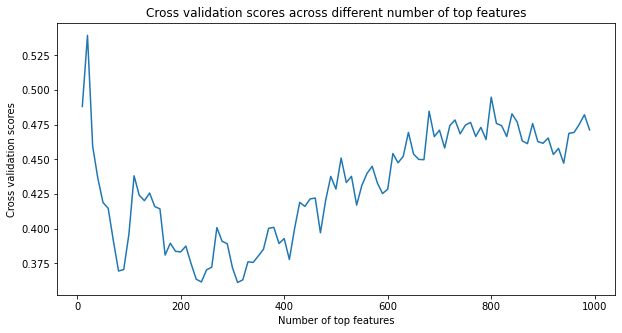

In [136]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=n_features, y=scores_n_features, ax=ax)
plt.title('Cross validation scores across different number of top features')
plt.xlabel('Number of top features')
plt.ylabel('Cross validation scores')

In [ ]:
# Check classification accuracy for each class separately.
arrs = []
for i in range(1000):
    X_test, X_train, y_test, y_train = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model.score(X_test, y_test)
    df = pd.concat(
        [y_test,
        pd.DataFrame(y_pred, columns=['predicted'], index=y_test.index)],
        axis=1).reset_index(drop=True)

    df['correct'] = df.apply(lambda x: True if x['predicted'] == x['hypnosis_depth'] else False, axis=1)
    arr = df.groupby('hypnosis_depth').agg({'correct': 'mean'}).values
    arrs.append(arr)
np.array(arrs).mean(axis=0)

## SVC (not nested CV)
Investigate how different types of features affect the SVC model.

In [51]:
# 1. DATA
DATA = pd.read_csv('data/classification_datasets/correlation_source.csv', index_col=0)

DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('condition.str.contains("experience")')
# DATA = DATA.query('procedure == "confusion" or procedure == "relaxation"')

#Xy
X = DATA.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session', 'condition',
                       'bids_id'])

col_name = ['DorsalAttention_lh ↔ DorsalAttention_rh (beta)',
            'VentralAttention_rh ↔ Frontoparietal_rh (beta)',
            'Somatomotor_lh ↔ Limbic_rh (beta)',
            'Limbic_rh ↔ Default_rh (beta)']
X = X[col_name]

y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)

In [41]:
# 2. Open results of importance and shap value analysis
import pickle
with open('data/classification_results/importances.pkl', 'rb') as f:
    importances = pickle.load(f)

with open('data/classification_results/shap_values.pkl', 'rb') as f:
    _shap_values = pickle.load(f)

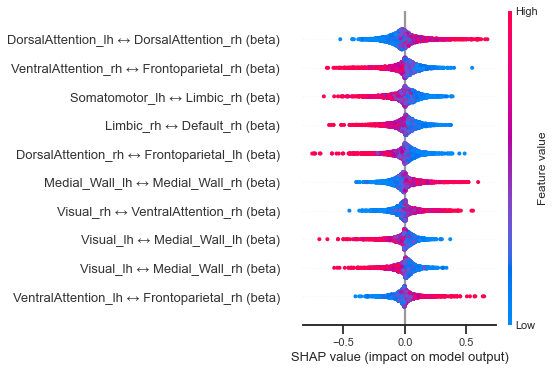

In [43]:
import shap
shap_keys = list(_shap_values.keys())[:3]
shap_values = {k:_shap_values[k] for k in shap_keys}
shap.summary_plot(shap_values['correlation source (beta)'], max_display=10)

In [48]:
# 2. Pipeline
pipe = Pipeline([
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('select', SelectFromModel(estimator=SVC(kernel='linear', probability=True))),
    ('clf', LinearSVC())
])

In [52]:
# open grid results and GET the BEST parameters
model_name = 'beta correlation source'
grid_results = pd.read_csv('data/classification_results/grid_results.csv', index_col=0)
grid_results['label'] = grid_results['param_extract__frequency_band'] + ' ' + grid_results['param_extract__kind']
idx = grid_results.groupby('label')['mean_test_score'].transform(max) == grid_results['mean_test_score']
grid_results = grid_results[idx]
grid_results.drop_duplicates(subset='label', inplace=True)
import ast
params = grid_results.query('label == @model_name')['params'].iloc[0]
keys = ['clf__C', 'select']
params = {k:v for k,v in ast.literal_eval(params).items() if k in keys}
pipe.set_params(**params)

model_performance = grid_results.query('label == @model_name')['mean_test_score'].iloc[0]

# scores with and without power of central sensors
CV = GroupShuffleSplit(n_splits=200, test_size=0.2)
groups = DATA['bids_id']

scores = cross_val_score(pipe, X, y, groups=groups, cv=CV, n_jobs=-1)
print(f' Model Performance \n With all features : {model_performance}, \n With Selected Features: {scores.mean()}')


 Model Performance 
 With all features : 0.6833225108225109, 
 With Selected Features: 0.6260281385281385


### RESULT
**power sensor (gamma)** building a model on top three features made an increase in accuracy by 5 percent to 69 percent.
**power source (theta)** Including only three top features in model building increase accuracy from 49 to 56. percents!
**correlation source (beta)** With this dataset including only three or four top features will decrease the accuracy to 62 percent (from 68).

## Randomized Search with nested CV

In [74]:
import scipy
NUM_TRIALS = 2
nested_scores = []
best_estimators = []
importances = []
test_accuraies = []

# Set up possible values of parameters to optimize over

p_distributions = {'clf__C': scipy.stats.expon(scale=100),
                   'clf__gamma': scipy.stats.expon(scale=.1),
                #    'clf__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                #    'clf__degree': scipy.stats.randint(1, 10),
                   'reduce__n_components': scipy.stats.randint(1, 20),
                   }

# We will use a Support Vector Classifier with "rbf" kernel
pipe = Pipeline([
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('reduce', PCA()),
    ('clf', SVC(kernel="linear", max_iter=-1, probability=True)),
])
# Loop for each trial
for i in tqdm(range(NUM_TRIALS)):

    # Choose cross-validation techniques for the inner and outer loops,
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=i)
    
    for train, test in outer_cv.split(X, y, groups=DATA['bids_id']):

        # Nested CV with parameter optimization
        clf = RandomizedSearchCV(pipe, param_distributions=p_distributions, n_iter=100,
                                cv=inner_cv, n_jobs=-1,
                                scoring='balanced_accuracy', error_score=0)
        clf.fit(X.iloc[train], y.iloc[train])
        best_estimators.append(clf.best_params_)
        nested_scores.append(clf.best_score_)
        y_pred = clf.predict(X.iloc[test])
        test_accuraies.append((y.iloc[test] == y_pred).mean())
        
        # perm_imp_results = permutation_importance(
        #     clf.best_estimator_, X.iloc[test], y.iloc[test], scoring='balanced_accuracy', n_repeats=30, n_jobs=-1)
        # importances.append(perm_imp_results['importances'])
        
    # nested_score = cross_validate(clf, X=X, y=y, cv=outer_cv, scoring=['balanced_accuracy'],
    #                               return_estimator=True)
#     nested_scores.append(nested_score['test_balanced_accuracy'])
# np.hstack(np.array(nested_scores)).mean()
C = np.array([best_estimators[i]['clf__C'] for i in range(len(best_estimators))]).mean()
gamma = np.array([best_estimators[i]['clf__gamma'] for i in range(len(best_estimators))]).mean()
n_component = round(np.array([best_estimators[i]['reduce__n_components'] for i in range(len(best_estimators))]).mean())
np.array(nested_scores).mean()

100%|██████████| 2/2 [19:33<00:00, 586.82s/it]


0.679861138861139

In [78]:
C, gamma, n_component

(58.479318522248114, 0.08828353759508438, 14)

### BayesSearch

In [ ]:
opt = BayesSearchCV(
    pipe,
    search_spaces={'clf__C': (0.01, 100.0, 'log-uniform'),
                   'clf__gamma': (0.001, 0.1, 'log-uniform'),},
    n_iter=1000,
    cv=5
)

opt.fit(X,
        y, 
        callback=[skopt.callbacks.DeadlineStopper(total_time=60*10)]
        )

pipe = opt.best_estimator_
scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
[f'{i}: mean = {scores[i].mean()}, std = {scores[i].std()}' for i in scores.keys()]

### Permutation test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


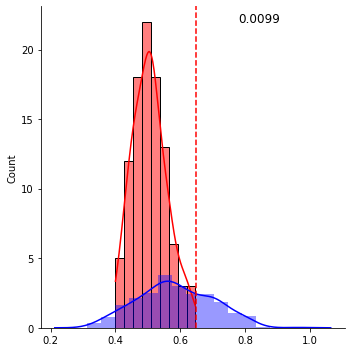

In [100]:
# permutation test
from sklearn.model_selection import permutation_test_score
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

# TODO why the score on the permuted sample is lower than baseline 
obs_score, perm_socres, p_value = permutation_test_score(
    pipe, X, y, cv=cv, scoring='balanced_accuracy', n_permutations=100, n_jobs=-1, verbose=3)

sns.displot(perm_socres, kde=True, color='red')
sns.distplot(scores_total, kde=True, color='blue')
plt.axvline(obs_score, color='r', linestyle='--')
plt.annotate(f'{p_value:.4f}', xy=(obs_score, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

In [ ]:
# bootstrap confidence interval
np.random.choice(scores, size=1000, replace=True).mean()

## Permutation Importance
Some of the results of my experiment:

First, I did permutation importance considering all 1770 features **(test_accuracy = 0.75)**

Using only the top five important features in my model yeilds still a significantly better performance than chance. **(test_accuracy = 0.66)**

Using the least five important feature yeilds terrible result: the distribution of scores is in quite overlap with the permuted scores. **(test_accuracy = 0.54)**

Using the top 200 important features in my model yeilds the best performance **(test_accuracy = 0.78)**

Taking all the features with positive, non-zero importance into account (n=984) won't change the model performance that much **(test_accuracy = 0.77)**

The best performance **(test_accuracy = 0.80)** , though with relatively high (=0.057) was achieved when the importance of included features were equal or higher than 0.00125.

On the contrary, when these exact features (the top 350 important features) were excluded, model's performance dropped drastically down to **0.60**

Next step was to do the permutation feature importance with the winner model: in this round, some features show a mean importance as high as 0.05, in contrast to the first round when the mean importance of the top feature was only 0.006! (This observation is definitely due to the stolen variance by those unimportant features in the first run!)

As running the permutation importance code was incredibly faster this time, we increased the number of repetation and our top feature got a mean importance of 0.08! The test accuracy this time was as high as **0.82** (By BayesianGrid search (n_iter=500, cv=5, callback time=5 min) test accuracy increased to **0.85**, std = 0.03858612300930076') But with each run of cross_validate() the acuuracy and std would differ, but it won't get lower than 0.8.

Problem of **data leakage**: when I only took the experience part of the data, the accuracy fell to **0.74** with a higher std (0.09), but this result was still beat the permuted classifier! (using only half of the data did not have such a effect (acc = 0.8 on first haf, 0.78 on second half)! so lower accuracy is not because of the smaller data) interestingly, in the permutation test, p_value is 0.3 when we use only the second half of the data and 0.01 when we use the first half. P_value remains 0.0099 when we only include the experience parts.

Dropping self conncetions and connections to M1 and M2 gave as an accuracy of 0.75 and std = 0.05.

The performance of the model with the aggregate connections across different brain areas was 0.62, std = 0.07 and scores' distribution had two peaks. That shows us one thing: by aggregating features we actually loose information and that highlights the importance of techniques that can handle high dimentionality.

Using real hypnosis with 252 most important features (described as hypnosis or not) the accuracy is **0.7**, and std = 0.06. taking only experience, or induction rows into account, classification performance is really poor: 0.6.

**Regression** I used SVR with the data from the conditions presented as hypnosis to participants, and doing BayesianSearch I got explained_variance = 0.21 and r2=0.20. Bayesian search gave us C=37.62399869785873, and gamma=0.01033864984323087.


# TODO compare the baseline of the hypnotizable and the non-hypnotizable.

In [30]:
from sklearn.inspection import permutation_importance
CV = GroupShuffleSplit(n_splits=5, test_size=0.2)
importances = []
for train, test in tqdm(CV.split(X, y, groups=DATA['bids_id']), total=CV.get_n_splits()):
    pipe.fit(X.iloc[train], y.iloc[train])
    perm_imp_results = permutation_importance(
        pipe, X.iloc[test], y.iloc[test], scoring='accuracy', n_repeats=5, n_jobs=-1)
    importances.append(perm_imp_results['importances'])
    
# model_importances = []
# CV = GroupShuffleSplit(n_splits=5, test_size=0.2)
# for train, test in tqdm(CV.split(X, y, groups=groups), total=CV.get_n_splits()):
    
#     model = pipe.fit(X.iloc[train], y.iloc[train])
    
#     perm_scores = permutation_importance(model, X.iloc[test], y.iloc[test], n_repeats=2, n_jobs=-1)
#     cv_importances = pd.DataFrame(perm_scores['importances'].T)
#     model_importances.append(cv_importances)


100%|██████████| 5/5 [02:03<00:00, 24.62s/it]


In [35]:
imp_df = pd.DataFrame(np.hstack(importances), index=X.columns)
imp_df.reset_index(inplace=True)
imp_df = imp_df.melt(id_vars=['index'])
imp_df.rename(columns={'index': 'feature', 'value': 'importance', 'variable': 'repetition'}, inplace=True)
imp_df['mean_importance'] = imp_df.groupby('feature')['importance'].transform('mean')
imp_df.sort_values(by='mean_importance', ascending=False, inplace=True)

# fig, ax = plt.subplots(figsize=(20, 5))
# # sns.barplot(x='importance', y='feature', data=imp_df1, orient='h', ax=ax, )
# sns.lineplot(x='feature', y='importance', data=imp_df1, ax=ax, ci=95)
# sns.scatterplot(x='feature', y='mean_importance', data=imp_df1, ax=ax)
# plt.xticks(rotation=45, fontsize='small', rotation_mode='anchor', ha='right')
# plt.xlabel('feature', fontsize='xx-large')
# plt.ylabel('importance', fontsize='xx-large')
# plt.suptitle('Permutation Importance', fontsize='xx-large')
# plt.show()

Text(0, 0.5, 'Feature name')

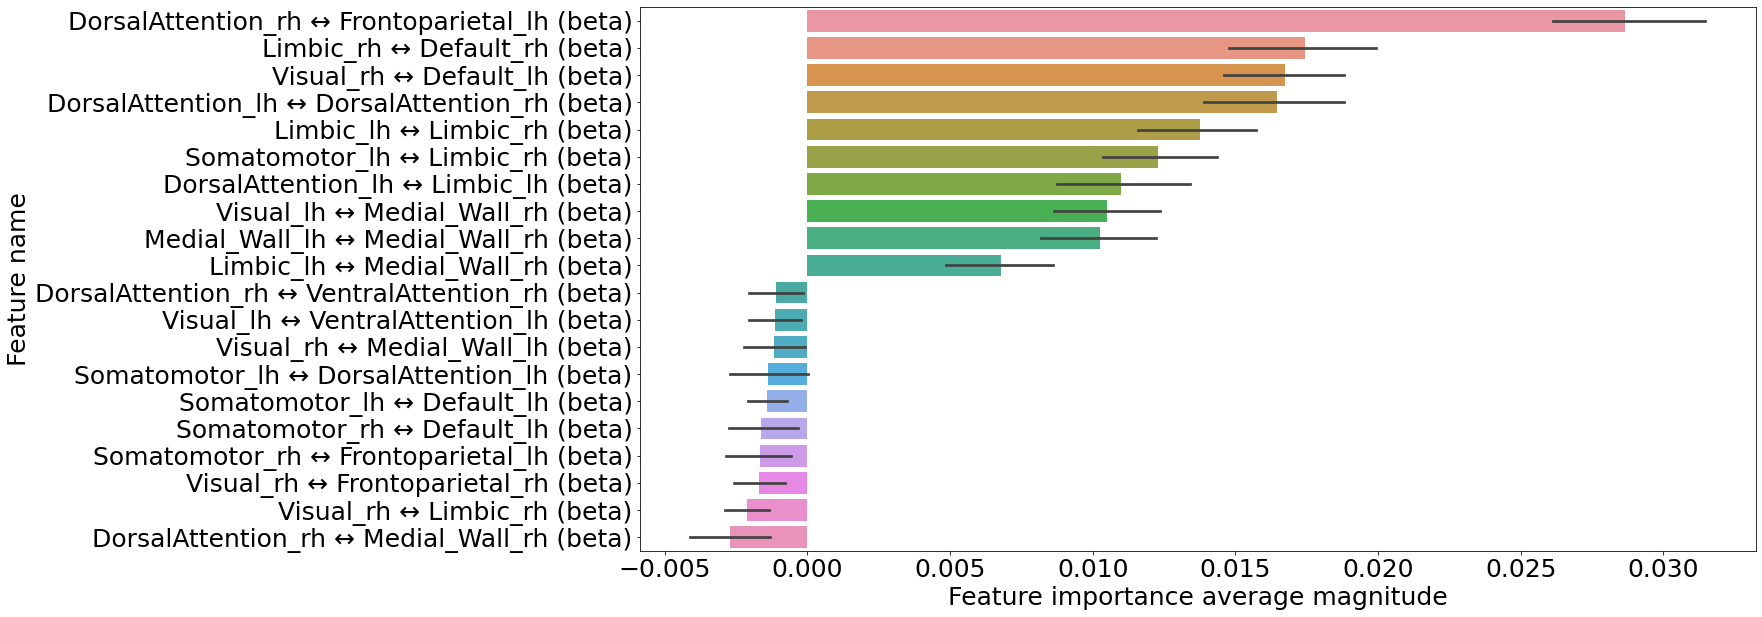

In [178]:
imp_df3 = imp_df.sort_values('mean_importance', ascending=False)[:30000]
imp_df2 = imp_df.sort_values('mean_importance', ascending=False)[-30000:]
df = pd.concat([imp_df3, imp_df2])
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x='importance', y='feature', data=df, orient='h', ax=ax)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Feature importance average magnitude', fontsize=25)
plt.ylabel('Feature name', fontsize=25)
# plt.title('Permutation Importance', fontsize='xx-large')

## Comparing conditions (baseline vs. experience)

### Xy

In [31]:
# read data
DATA = pd.read_csv('data/classification_datasets/connectivities_yeo7nets_others.csv', index_col=0)

DATA = DATA.query('condition == "baseline2" or description == "hypnosis"')

DATA = DATA.query('procedure == "confusion" or procedure == "relaxation" or condition == "baseline2"')

#Xy
X = DATA.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session', 'condition',
                       'bids_id'])

col_name = [col for col in X.columns if 'theta' in col]
X = X[col_name]

y = DATA['condition'].apply(lambda x: 'baseline' if x == 'baseline2' else 'experinece')
y.value_counts()

baseline      52
experinece    51
Name: condition, dtype: int64

In [32]:
pipe = Pipeline([
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    # ('selectper', SelectPercentile(mutual_info_classif, percentile=80)),
    ('select', SelectFromModel(SVC(kernel='linear'))),
    # ('reduce', PCA(n_components=10)),
    ('clf', SVC(kernel="linear", max_iter=-1, probability=True)),
    # ('clf', DummyClassifier(strategy='most_frequent'))
    # ('clf', RandomForestClassifier(n_estimators=100))
])

# computing cross valided scores with multiple metric evaluation
scoring = ['accuracy']

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100)
# scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_estimator=True)
# scores['test_balanced_accuracy'].mean()
scores_total = []
for i in range(100):
    # cross validation strategies
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True).split(X, y, groups=DATA['bids_id'])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)['test_accuracy']
    scores_total.append(scores)
scores_total = np.hstack(np.array(scores_total))
scores_total.mean(), scores_total.std()

(0.6226554112554112, 0.10490362890819356)

/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


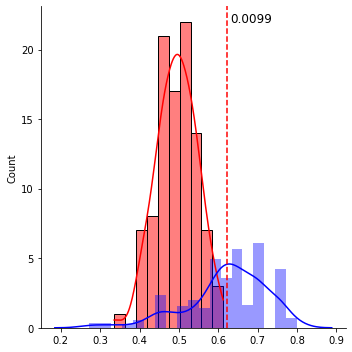

In [66]:
# permutation test
from sklearn.model_selection import permutation_test_score
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

# TODO why the score on the permuted sample is lower than baseline 
obs_score, perm_socres, p_value = permutation_test_score(
    pipe, X, y, cv=cv, scoring='balanced_accuracy', n_permutations=100, n_jobs=-1, verbose=0)

sns.displot(perm_socres, kde=True, color='red')
sns.distplot(scores_total, kde=True, color='blue')
plt.axvline(obs_score, color='r', linestyle='--')
plt.annotate(f'{p_value:.4f}', xy=(obs_score, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

## Baseline Correction

In [29]:
# read and modify data
DATA = pd.read_csv('data/classification_datasets/connectivities_yeo7nets_others.csv', index_col=0)

DATA = DATA.query('condition == "baseline2" or description == "hypnosis"')

DATA.drop(id_col, axis=1, inplace=True) # drop identical columns

#Xy
X = DATA.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session'])

# normalize data
def normalize_connectivities(df):
    df.set_index('condition', inplace=True)
    baseline = df.loc['baseline2']
    df = df.apply(lambda x: x/baseline, axis=1)
    return df
   
X = X.groupby('bids_id').apply(normalize_connectivities)
X = X.drop(columns='bids_id')
X = X.query('condition != "baseline2"')
X = X.reset_index().sort_values(['bids_id', 'condition']).drop(columns=['condition', 'bids_id'])

col_name = [col for col in X.columns if 'gamma' in col]
X = X[col_name]

DATA = DATA.query('condition != "baseline2"').reset_index()
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)
y.value_counts(normalize=True)

1    0.572816
0    0.427184
Name: hypnosis_depth, dtype: float64

In [30]:
pipe = Pipeline([
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    # ('selectper', SelectPercentile(mutual_info_classif, percentile=80)),
    ('select', SelectFromModel(SVC(kernel='linear'))),
    # ('reduce', PCA(n_components=10)),
    ('clf', SVC(kernel="linear", max_iter=-1, probability=True)),
    # ('clf', DummyClassifier(strategy='most_frequent'))
    # ('clf', RandomForestClassifier(n_estimators=100))
])

# computing cross valided scores with multiple metric evaluation
scoring = ['accuracy']

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100)
# scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_estimator=True)
# scores['test_balanced_accuracy'].mean()
scores_total = []
for i in range(100):
    # cross validation strategies
    cv = StratifiedGroupKFold(n_splits=5, shuffle=True).split(X, y, groups=DATA['bids_id'])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)['test_accuracy']
    scores_total.append(scores)
scores_total = np.hstack(np.array(scores_total))
scores_total.mean(), scores_total.std()

(0.546751424014582, 0.11450775797892104)

## SHAP

In [ ]:
import shap

shap_values_cv = []
X_test_indexes_cv = []
y_test_cv = []
y_pred_cv = []

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
pca = PCA(n_components=pipe.named_steps['reduce'].n_components_)

for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    X_train_reduced = pca.fit_transform(X.iloc[train])
    X_test_reduced = pca.fit_transform(X.iloc[test])
    pipe.fit(X.iloc[train], y.iloc[train])
    y_pred = pipe.predict(X.iloc[test])
    # TODO: check if model is a treebased one, otherwise use shap.Explainer and clf.predict_proba
    # for treebased models, use TreeExplainer and clf.named_steps['clf']
    explainer = shap.KernelExplainer(pipe.named_steps['clf'].predict_proba, data=X_train_reduced,
                                   output_names=pipe.named_steps['clf'].classes_)
    _shap_values = explainer.shap_values(X_test_reduced)
    shap_values_cv.append(_shap_values)
    X_test_indexes_cv.append(test)
    y_test_cv.append(y.iloc[test])
    y_pred_cv.append(y_pred)

In [ ]:
# merge shap_values_cv into a single shap values array

X_test = X.iloc[np.hstack(X_test_indexes_cv)]
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

shap_values = shap.Explanation(
    values=np.vstack([sh.values for sh in shap_values_cv]),
    base_values=np.vstack([sh.base_values for sh in shap_values_cv]),
    data=np.vstack([sh.data for sh in shap_values_cv]),
    feature_names=shap_values_cv[0].feature_names,
    output_names=shap_values_cv[0].output_names,
    output_indexes=y_pred
)

# Classification with unaggregated gamma power.

In [20]:
# change columns name
epochs = mne.read_epochs('data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif', verbose=0)
ch_names = epochs.ch_names
[ch_names.remove(i) for i in ['M1', 'M2', 'EOG1', 'EOG2', 'ECG']]
all_channels = epochs.ch_names

ba_list = {'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5', 'FT7'],
 'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5'],
 'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
 'LO': ['O1', 'PO3'],
 'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6', 'FT8'],
 'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6'],
 'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
 'RO': ['O2', 'PO4'],
 'FZ': ['Fpz', 'Fz'],
 'CZ': ['Cz', 'CPz'],
 'PZ': ['Pz', 'POz'],
 'OZ': ['Oz', 'Iz'],
 'all': ch_names
}

In [21]:
# open power data
import pickle
with open('docs/1.psd_unaggragated_2nd_analysis.pkl', 'rb') as f:
    psd = pickle.load(f)

In [22]:
# build a dataframe of unaggregated gamma power
df = pd.DataFrame()
for k, v in psd.items():
    if 'baseline' in k:
        base = psd[k].mean(0)[:, 1:4].mean(1) 
        # base = 20 * np.log10(psd[k].mean(0)[:, 4:8].mean(1))
    else:
        # psd_transformed = 20 * np.log10(psd[k].mean(0)[:, 4:8].mean(1))
        # psd_transformed = psd_transformed - base
        psd_transformed = psd[k].mean(0)[:, 13:40].mean(1) * 1000000**2
        temp = []
        for key in ba_list.keys():
            ind = [all_channels.index(i) for i in ba_list[key]]
            temp.append(psd_transformed[ind].mean(0))
        
        df_ = pd.DataFrame(temp, columns=[k])               
        df = df.join(df_, how='outer')
df = df.T
df.columns = ba_list.keys()

# open behavioral data and ids map
bh = pd.read_csv('data/behavioral_data/archived/plb_hyp_data.csv', index_col='index')
ids_map = pd.read_excel('docs/ids_map.xlsx', header=1, index_col='behavioral_id')
ids_map = ids_map.drop_duplicates('bids_id')
ids_map = ids_map[['bids_id']]
ids_map['bids_id'] = ids_map['bids_id'].apply(lambda x:str(x).zfill(2))
bh = bh.join(ids_map, how='right')
bh = bh.melt(
    id_vars=['procedure_type_1', 'procedure_type_2', 'procedure_type_3', 'procedure_type_4', 'bids_id',
            'description_type_1', 'description_type_2', 'description_type_3', 'description_type_4'],
    value_vars=['hypnosis_depth_1', 'hypnosis_depth_2', 'hypnosis_depth_3', 'hypnosis_depth_4'])
bh['session'] = bh['variable'].apply(lambda x:x.split('_')[2])
bh['procedure'] = bh.apply(lambda r: r['procedure_type_'+r['session']], axis=1)
bh['description'] = bh.apply(lambda r: r['description_type_'+r['session']], axis=1)
bh = bh[['bids_id', 'value', 'procedure', 'description', 'session']].sort_values(by=['bids_id', 'session']).set_index('bids_id')
bh = bh.rename(columns={'value':'hypnosis_depth'})
bh.reset_index(inplace=True)

# merge connectivity data with behavioral data
df[['bids_id', 'condition']] = df.index.to_series().apply(lambda x:x.split('-')).apply(pd.Series)
df['session'] = df['condition'].apply(lambda x:x[-1])
df.reset_index(drop=True, inplace=True)
df = pd.merge(bh, df, how='right', on=['session', 'bids_id'], right_index=False)
df = df.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
df.insert(1, 'condition', df.pop('condition'))

In [16]:
gamma_feature_names = ['Hypnosis Depth',
                       'Left Frontal',
                       'Left Central',
                       'Left Parietal',
                       'Left Occipital',
                       'Right Frontal',
                       'Right Central',
                       'Right Parietal',
                       'Right Occipital',
                       'Midline Frontal',
                       'Midline Central',
                       'Midline Parietal',
                       'Midline Occipital',
                       'All']
df_new = df.query("description=='hypnosis'")
df_new = df_new[df_new.condition.str.contains('experience')].reset_index(drop=True)

power_cols = list(df_new.columns[df_new.dtypes == 'float64'])
[power_cols.insert(0, i) for i in ['condition', 'bids_id']]
df_new = df_new[power_cols]

# create a condition

# df_new.columns = gamma_feature_names
# df_new = df_new.round(3)
df_new


,bids_id,condition,hypnosis_depth,LF,LC,LP,LO,RF,RC,RP,RO,FZ,CZ,PZ,OZ,all
0,01,experience1,6.0,9.727260,0.525178,0.267453,0.188131,0.270818,0.307339,0.228659,0.127707,0.120105,0.120263,0.176065,0.143999,1.432882
1,01,experience3,8.0,6.675887,0.183131,0.136520,0.386604,0.158437,0.116156,0.140958,0.251763,0.117166,0.120657,0.194671,0.496120,0.972377
2,02,experience2,0.0,34.918732,0.212123,0.255213,0.507031,0.348477,0.184817,0.301448,0.355726,0.286319,0.191324,0.315580,0.410178,4.533949
3,02,experience3,1.0,26.743916,0.206698,0.243418,0.430167,0.276668,0.186431,0.291227,0.365129,0.241597,0.202936,0.281819,0.315062,3.509332
4,03,experience1,7.0,5.503674,0.259312,0.244686,1.115014,0.522478,0.263315,0.248205,0.664487,0.311273,0.383827,0.308700,2.376614,1.058123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,49,experience3,2.0,35.745269,0.690793,0.432176,0.682404,0.556681,0.684041,1.271585,0.659021,0.379763,0.321548,0.425645,0.591508,4.978648
98,50,experience3,7.0,10.023154,0.170252,0.186444,0.326720,0.229013,0.173305,0.202004,0.272441,0.138966,0.165270,0.325275,0.266667,1.411602
99,50,experience4,7.0,9.149716,0.159441,0.179259,0.319805,0.207605,0.151257,0.200515,0.272637,0.150745,0.158416,0.298978,0.260159,1.294905
100,51,experience3,7.0,23.595425,0.154214,0.124847,0.203293,0.185486,0.156164,0.124139,0.176394,0.122797,0.084272,0.133700,0.213273,3.027953


In [49]:
# prepare Xy

# read data
df2 = df.query('description == "hypnosis"')
df2 = df2.query('condition.str.contains("experience")')

# DATA = DATA.query('procedure == "confusion" or procedure == "relaxation"')

#Xy
X = df2.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session', 'condition',
                       'bids_id'])


y = df2['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)

In [51]:
groups = df2['bids_id']
CV = StratifiedGroupKFold(shuffle=True)

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    # ('scale', StandardScaler()),
    ('select', 'passthrough'),
    ('clf', LinearSVC(max_iter=1000000, C=0.1, dual=True, class_weight='balanced')),
])
scores = []
for i in tqdm(range(100)):
    score = cross_val_score(pipe, X, y, cv=CV, groups=groups, scoring='accuracy')
    scores.append(score)
np.array(scores).mean()

100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


0.49264545454545455

Conclusion:
- coverting volt to microvolt can affect the model perfromance!! Higher performance with power in volt. Maybe it has to do with rounding and scaling!

- The power I used in GridSearch was not baseline corrected, Baseline correction reduce models accuracy. In other word the model trained with absolute power has a higher performance than a model with relative power! Is it related to the individual differences?? #TODO: I should try other transformations as well! (decibel, percentage and Z-transform!) AAA, bacause of the scaling in my pipeline I actually do the Z transformation!!!

- aggregated power over pre-defined brain patches had a better performance than non-aggregated power.

(array([270., 125.,  60.,  29.,  12.,   2.,  10.,   3.,   4.,   1.]),
 array([1.44121649e-14, 5.87938987e-14, 1.03175633e-13, 1.47557367e-13,
        1.91939100e-13, 2.36320834e-13, 2.80702568e-13, 3.25084302e-13,
        3.69466036e-13, 4.13847770e-13, 4.58229504e-13]),
 <BarContainer object of 10 artists>)

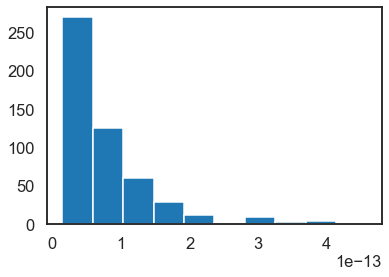

In [67]:
# Histogram of the data after logarithmic transformation
power = pd.read_csv('data/classification_datasets/power_sensor.csv', index_col=0)
x = power['LO-lowergamma']
plt.hist(10**(x/10))

(array([15., 72., 92., 85., 87., 60., 61., 23., 13.,  8.]),
 array([-138.41270779, -136.91035396, -135.40800013, -133.90564631,
        -132.40329248, -130.90093865, -129.39858482, -127.896231  ,
        -126.39387717, -124.89152334, -123.38916952]),
 <BarContainer object of 10 artists>)

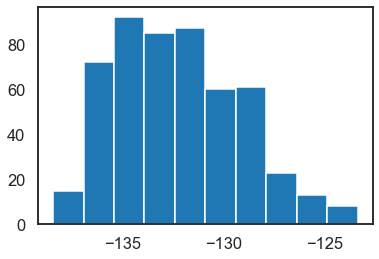

In [68]:
plt.hist(x)

# New PSDs

In [2]:
# imports
from mne.time_frequency import psd_array_welch
import mne
from pathlib import Path
import re
import pickle

In [5]:
# overlapping power with longer window,
# new power boundries,

psds_path = 'docs/psds_3th_higher_frequency_resolution.pkl'
if Path(psds_path).exists():
    with open(psds_path, 'rb') as handle:
        psds_dict = pickle.load(handle)

    # save frequencies in a different object
    freqs = psds_dict['freqs']
    psds_dict.pop('freqs')

else:
    print('>>>>>> There is no PSDs in the current directory, creating a PSDs dictionary...')
    psds_dict = {}
    for path in sorted(Path('data/clean_data/').glob('*.fif')):
        subject, task = re.search('sub-(.*)_ses-01_task-(.*)_proc-clean_epo.*', path.stem).groups()
        if task.__contains__('experience'):
            epochs = mne.read_epochs(path)
            data = np.hstack(epochs.get_data())
            psds,freqs = psd_array_welch(data,
                                    sfreq=1000,
                                    fmin=1,
                                    fmax=42,
                                    n_fft=8000,
                                    n_overlap=0.5
                                    )
            psds_dict[subject+'_'+task] = psds

    psds_dict['freqs'] = freqs
    with open(psds_path, 'wb') as handle:
        pickle.dump(psds_dict, handle)

In [ ]:
# define brain patches and frequency boundries
## channels name
epochs = mne.read_epochs('data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif', verbose=0)
ch_names = epochs.ch_names
[ch_names.remove(i) for i in ['M1', 'M2', 'EOG1', 'EOG2', 'ECG']]
all_channels = epochs.ch_names

# name of electrode groups
ba_patches = {'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5'],
 'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5', 'FT7'],
 'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
 'LO': ['O1', 'PO3'],
 'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6',],
 'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6', 'FT8'],
 'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
 'RO': ['O2', 'PO4'],
 'FZ': ['Fpz', 'Fz'],
 'CZ': ['Cz', 'FCz'],
 'PZ': ['Pz', 'CPz'],
 'OZ': ['POz', 'Oz', 'Iz'],
 'all': ch_names
}

# index of electrode groups
ba_patches_ind = {}
for k,v in ba_patches.items():
    temp = [all_channels.index(i) for i in v]
    ba_patches_ind[k] = temp

# frequency indces
freq = dict(delta=(0, 23),
            theta=(24, 55),
            alpha=(56, 95),
            beta=(96, 233),
            gamma=(234, 329))

# re-check the indeces of the frequency boundries
# delta = freqs[0:23]
# theta = freqs[24:55]
# alpha = freqs[56:95]
# beta = freqs[96:233]
# gamma = freqs[234:329]

In [147]:
# create a dataframe from aggreagated data, power in picovolts
psds_agg = {}
for k1, v1 in psds_dict.items():
    for k2, v2 in ba_patches_ind.items():
        for k3, v3 in freq.items():
            psds_agg[k1+'-'+k2+'_'+k3] = v1[v2].mean(0)[v3[0]:v3[1]].mean(0) * 10000 ** 3 #picovolts
            
df = pd.DataFrame(psds_agg.items(), columns=['index', 'values']).set_index('index')
df[['session', 'power']] = df.index.to_series().apply(lambda x:x.split('-')).apply(pd.Series)
df.reset_index(drop=True, inplace=True)
df = df.pivot(index='session', columns='power', values='values')

In [148]:
# merge behavioral data with power data
# open behavioral data
bh = pd.read_csv('data/behavioral_data/behavioral_data.csv')
bh = bh.iloc[:208]

# merge with power data
df[['bids_id', 'condition']] = df.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
df['session'] = df['condition'].apply(lambda x:x[-1])
df.reset_index(drop=True, inplace=True)
df['session'] = df['session'].astype('int64') # change the session col type to be the same type as the behavioral data
df = pd.merge(bh, df, how='right', on=['session', 'bids_id'], right_index=False)
df.insert(1, 'condition', df.pop('condition'))
df = df.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)

# Save
# df.to_csv('data/classification_datasets/power_sesnor_2nd.csv', index=0)

# Classification with NEW PSDs

In [1]:
# imports
import pandas as pd
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import (GridSearchCV, GroupShuffleSplit,
                                     StratifiedGroupKFold, cross_val_score, cross_validate)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.svm import SVC, LinearSVC

In [2]:
# load grid results from 
grid_results = pd.read_csv('data/classification_results/grid_results.csv')  
grid_results = grid_results.query('param_extract__kind == "power sensor"') # only power sensor grid results
grid_results['label'] = grid_results['param_extract__frequency_band'] + ' ' + grid_results['param_extract__kind']
idx = grid_results.groupby('label')['mean_test_score'].transform(max) == grid_results['mean_test_score']
grid_results = grid_results[idx].reset_index()
params = grid_results[['label', 'mean_test_score', 'std_test_score', 'param_select', 'param_clf__C']]

In [92]:
power = pd.read_csv('data/classification_datasets/power_sensor_2nd.csv', index_col=0)

# remove subject 52
power = power.iloc[:204]

# get only hypnosis conditions
power = power.query('description == "hypnosis"')

# output feature
y = power['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1)

# input features
col_name = [i for i in power.columns if 'delta' in i]
X = power[col_name]

# transform data
X = X.apply(lambda x:np.log10(x/(10000 ** 3)))

# CV and groups
CV = GroupShuffleSplit(n_splits=200, test_size=0.2)
groups = power['bids_id']

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    # ('select', SelectFromModel(estimator=SVC(kernel='linear'))),
    ('clf', LinearSVC(max_iter=1000000, C=0.1, dual=True, class_weight='balanced')),
])

scores = cross_val_score(pipe, X, y, groups=groups, scoring='accuracy', cv=CV, n_jobs=-1)
scores.mean(), scores.std()

(0.47181818181818175, 0.11120675406089474)

In [66]:
params

,label,mean_test_score,param_select,param_clf__C
0,beta power sensor,0.608636,passthrough,0.1
1,gamma power sensor,0.640844,passthrough,0.1
2,theta power sensor,0.548723,SelectFromModel(estimator=SVC(kernel='linear')),0.5
3,delta power sensor,0.500260,passthrough,100.0
4,alpha power sensor,0.565238,passthrough,100.0


Beta power data is more accurately classified by 2-3 percent when transformed logarithmically (accuracy = 0.64). Logarithmic transformation, in fact, benefits only this feature set.